In [28]:
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
sys.path.append('/Users/khalilouardini/Desktop/projects/scVI/scvi')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 0. import ete3 Tree

In [126]:
from ete3 import Tree

#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/scvi/data/Cassiopeia_trees/3726_NT_T1_tree.processed.collapsed.tree"
#tree_name = "/Users/khalilouardini/Desktop/projects/scVI/tests/data/richard_tree.nw"
tree_name = '/Users/khalilouardini/Desktop/projects/scVI/tests/data/toy.nw'

#with open(tree_name, "r") as myfile:
#    tree_string = myfile.readlines()
#    tree = Tree(tree_string[0], 1)

tree = Tree(tree_name, 1)

#tree = Tree()
#tree.populate(60)

for i, n in enumerate(tree.traverse('levelorder')):
    n.add_features(index=i)

In [127]:
print(tree)


   /-1
  |
  |-- /-3
  |
  |   /-5
--|--|
  |   \- /-7
  |
  |   /-9
  |  |
   \-|-- /-12
     |
     |   /-13
      \-|
         \- /-15


In [128]:
# Data
from anndata import AnnData
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from dataset.tree import TreeDataset, GeneExpressionDataset
from dataset.poisson_glm import Poisson_GLM
from dataset.anndataset import AnnDatasetFromAnnData

# Models
from models import *;
import scanpy as sc
from inference.tree_inference import TreeTrainer
from inference.inference import UnsupervisedTrainer
from inference import posterior
from models.treevae import TreeVAE

# Utils
from utils.data_util import get_leaves, get_internal
from utils.metrics import ks_pvalue, accuracy_imputation, correlations, knn_purity, knn_purity_stratified
from utils.plots_util import plot_histograms, plot_scatter_mean, plot_ecdf_ks, plot_density
from utils.plots_util import plot_losses, plot_elbo, plot_common_ancestor, plot_one_gene
from utils.baselines import avg_weighted_baseline, scvi_baseline, scvi_baseline_z, cascvi_baseline_z

# 1. Simulations

In [131]:
d = 5
g = 100
vis = False
leaves_only = False
var = 1.0

#glm = Poisson_GLM(tree_name, g, d, vis, leaves_only, var)
glm = Poisson_GLM(tree, g, d, vis, leaves_only, var)

glm.simulate_latent()

In [132]:
glm.simulate_ge()
# Quality Control (i.e Gene Filtering)
glm.gene_qc()
print("Proportion of dropouts: {}".format(np.mean(glm.X == 0)))
glm.X.shape

Proportion of dropouts: 0.3451388888888889


(16, 90)

In [133]:
glm.binomial_thinning(p=0.05)
print("Proportion of dropouts: {}".format(np.mean(glm.X == 0)))

Proportion of dropouts: 0.8131944444444444


/Users/khalilouardini/Desktop/projects/scVI/scvi/utils/plots_util.py:47: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


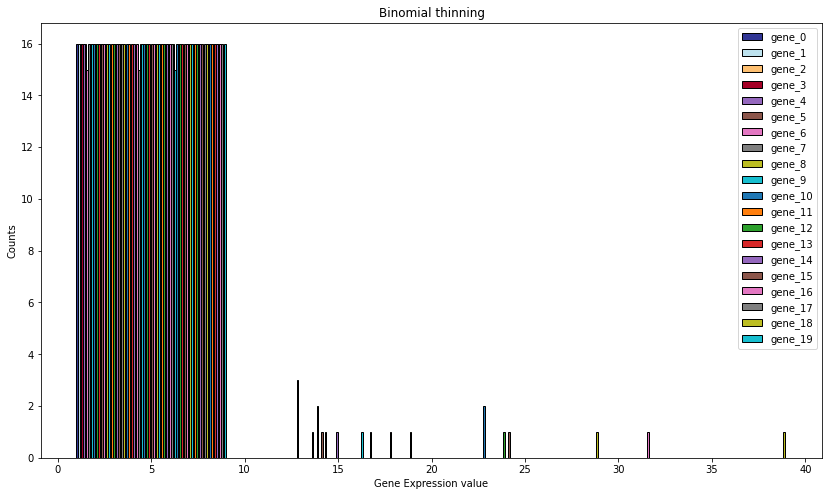

In [134]:
plot_histograms(glm.X, 'Binomial thinning')

In [135]:
# Latent vectors
leaves_z, _, _ = get_leaves(glm.z, glm.mu, tree)

#FIXED training set
leaves_X, leaves_idx, mu = get_leaves(glm.X, glm.mu, tree)

# internal nodes data (for imputation)
internal_X, internal_idx, internal_mu = get_internal(glm.X, glm.mu, tree)

leaves_X.shape, mu.shape, internal_X.shape, internal_mu.shape, leaves_z.shape

((8, 90), (8, 90), (8, 90), (8, 90), (8, 5))

***Simulated latent space***

In [136]:
#plot_common_ancestor(tree,
#                     glm.z,
#                     embedding='umap',
#                     give_labels=False
#                    )

# 2. CascVI

In [158]:
import scanpy as sc

# anndata + gene and celle filtering
adata = AnnData(leaves_X)
adata.obs_names = [n.name for n in list(tree.get_leaves())]
scvi_dataset = AnnDatasetFromAnnData(adata)
scvi_dataset.initialize_cell_attribute('barcodes', adata.obs_names)

[2021-03-23 16:14:22,512] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-23 16:14:22,513] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-03-23 16:14:22,515] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-03-23 16:14:22,516] INFO - scvi.dataset.dataset | Downsampled from 8 to 8 cells


In [159]:
# treeVAE
import copy

tree_bis = copy.deepcopy(tree)
cas_dataset = TreeDataset(scvi_dataset, tree=tree_bis)
cas_dataset

[2021-03-23 16:14:22,555] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2021-03-23 16:14:22,555] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2021-03-23 16:14:22,556] INFO - scvi.dataset.dataset | Keeping 90 genes
[2021-03-23 16:14:22,557] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-03-23 16:14:22,559] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-23 16:14:22,559] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-03-23 16:14:22,561] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-23 16:14:22,562] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2021-03-23 16:14:22,563] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2021-03-23 16:14:22,565] INFO - scvi.dataset.dataset | Downsampled from 8 to 8 cells


GeneExpressionDataset object with n_cells x nb_genes = 8 x 90
    gene_attribute_names: 'gene_names'
    cell_attribute_names: 'local_means', 'barcodes', 'labels', 'local_vars', 'batch_indices'
    cell_categorical_attribute_names: 'batch_indices', 'labels'

In [160]:
n_epochs = 200
lr = 1e-4

# No batches beacause of the message passing
use_batches = False
use_cuda = False

In [161]:
vae = TreeVAE(cas_dataset.nb_genes,
              tree = cas_dataset.tree,
              n_batch=cas_dataset.n_batches * use_batches,
              n_latent=glm.latent,
              n_hidden=16,
              n_layers=1,
              reconstruction_loss='poisson',
              prior_t = var,
             )

***Training***

In [162]:
freq = 10
trainer = TreeTrainer(
    model = vae,
    gene_dataset = cas_dataset,
    train_size=1.0,
    test_size=0,
    use_cuda=use_cuda,
    frequency=freq,
    n_epochs_kl_warmup=None
)

train_leaves:  [[0], [1], [2], [3], [4], [5], [6], [7]]
test_leaves:  []
validation leaves:  []


In [163]:
trainer.train(n_epochs=n_epochs,
              lr=lr)

computing elbo
training:   0%|          | 0/200 [00:00<?, ?it/s]Encodings MP Likelihood: 68.54409847490005
ELBO Loss: 308.82787815878595
Encodings MP Likelihood: 67.63814073006057
ELBO Loss: 299.41012548327717
Encodings MP Likelihood: 67.12934022967066
ELBO Loss: 305.8338039968268
Encodings MP Likelihood: 65.90996502480075
ELBO Loss: 310.1732089323859
Encodings MP Likelihood: 70.01298113953135
ELBO Loss: 305.7256932808327
Encodings MP Likelihood: 69.37606656233244
ELBO Loss: 299.98848335449986
Encodings MP Likelihood: 69.22860193976562
ELBO Loss: 307.61885260299385
Encodings MP Likelihood: 61.87924577839178
ELBO Loss: 317.41951309062546
Encodings MP Likelihood: 63.84444297857437
ELBO Loss: 313.5197098490878
Encodings MP Likelihood: 72.17877644811436
ELBO Loss: 301.0992051561654
computing elbo
Encodings MP Likelihood: 65.88221295529546
ELBO Loss: 299.5979849772823
Encodings MP Likelihood: 64.2223310144413
ELBO Loss: 307.14840005677854
Encodings MP Likelihood: 63.83059723542431
ELBO Loss

training:  55%|█████▍    | 109/200 [00:00<00:00, 169.83it/s]Encodings MP Likelihood: 65.56127603152757
ELBO Loss: 309.16826831927943
computing elbo
Encodings MP Likelihood: 65.81315893679204
ELBO Loss: 299.80683934537495
Encodings MP Likelihood: 72.998204060822
ELBO Loss: 302.924120360991
Encodings MP Likelihood: 65.28098001837355
ELBO Loss: 291.0905957185976
Encodings MP Likelihood: 70.59844333033921
ELBO Loss: 304.3366209032763
Encodings MP Likelihood: 64.93805746106577
ELBO Loss: 300.87685177600224
Encodings MP Likelihood: 72.12632896098877
ELBO Loss: 305.30221265637084
Encodings MP Likelihood: 66.57957808078297
ELBO Loss: 287.3849233179386
Encodings MP Likelihood: 75.80821492478304
ELBO Loss: 306.1528128204507
Encodings MP Likelihood: 66.8893880761928
ELBO Loss: 307.7737078895104
Encodings MP Likelihood: 68.06258352930419
ELBO Loss: 290.1685483452549
computing elbo
Encodings MP Likelihood: 65.36365035472288
ELBO Loss: 305.90873640413224
Encodings MP Likelihood: 68.73069311926585
EL

/Users/khalilouardini/Desktop/projects/scVI/scvi/utils/plots_util.py:289: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


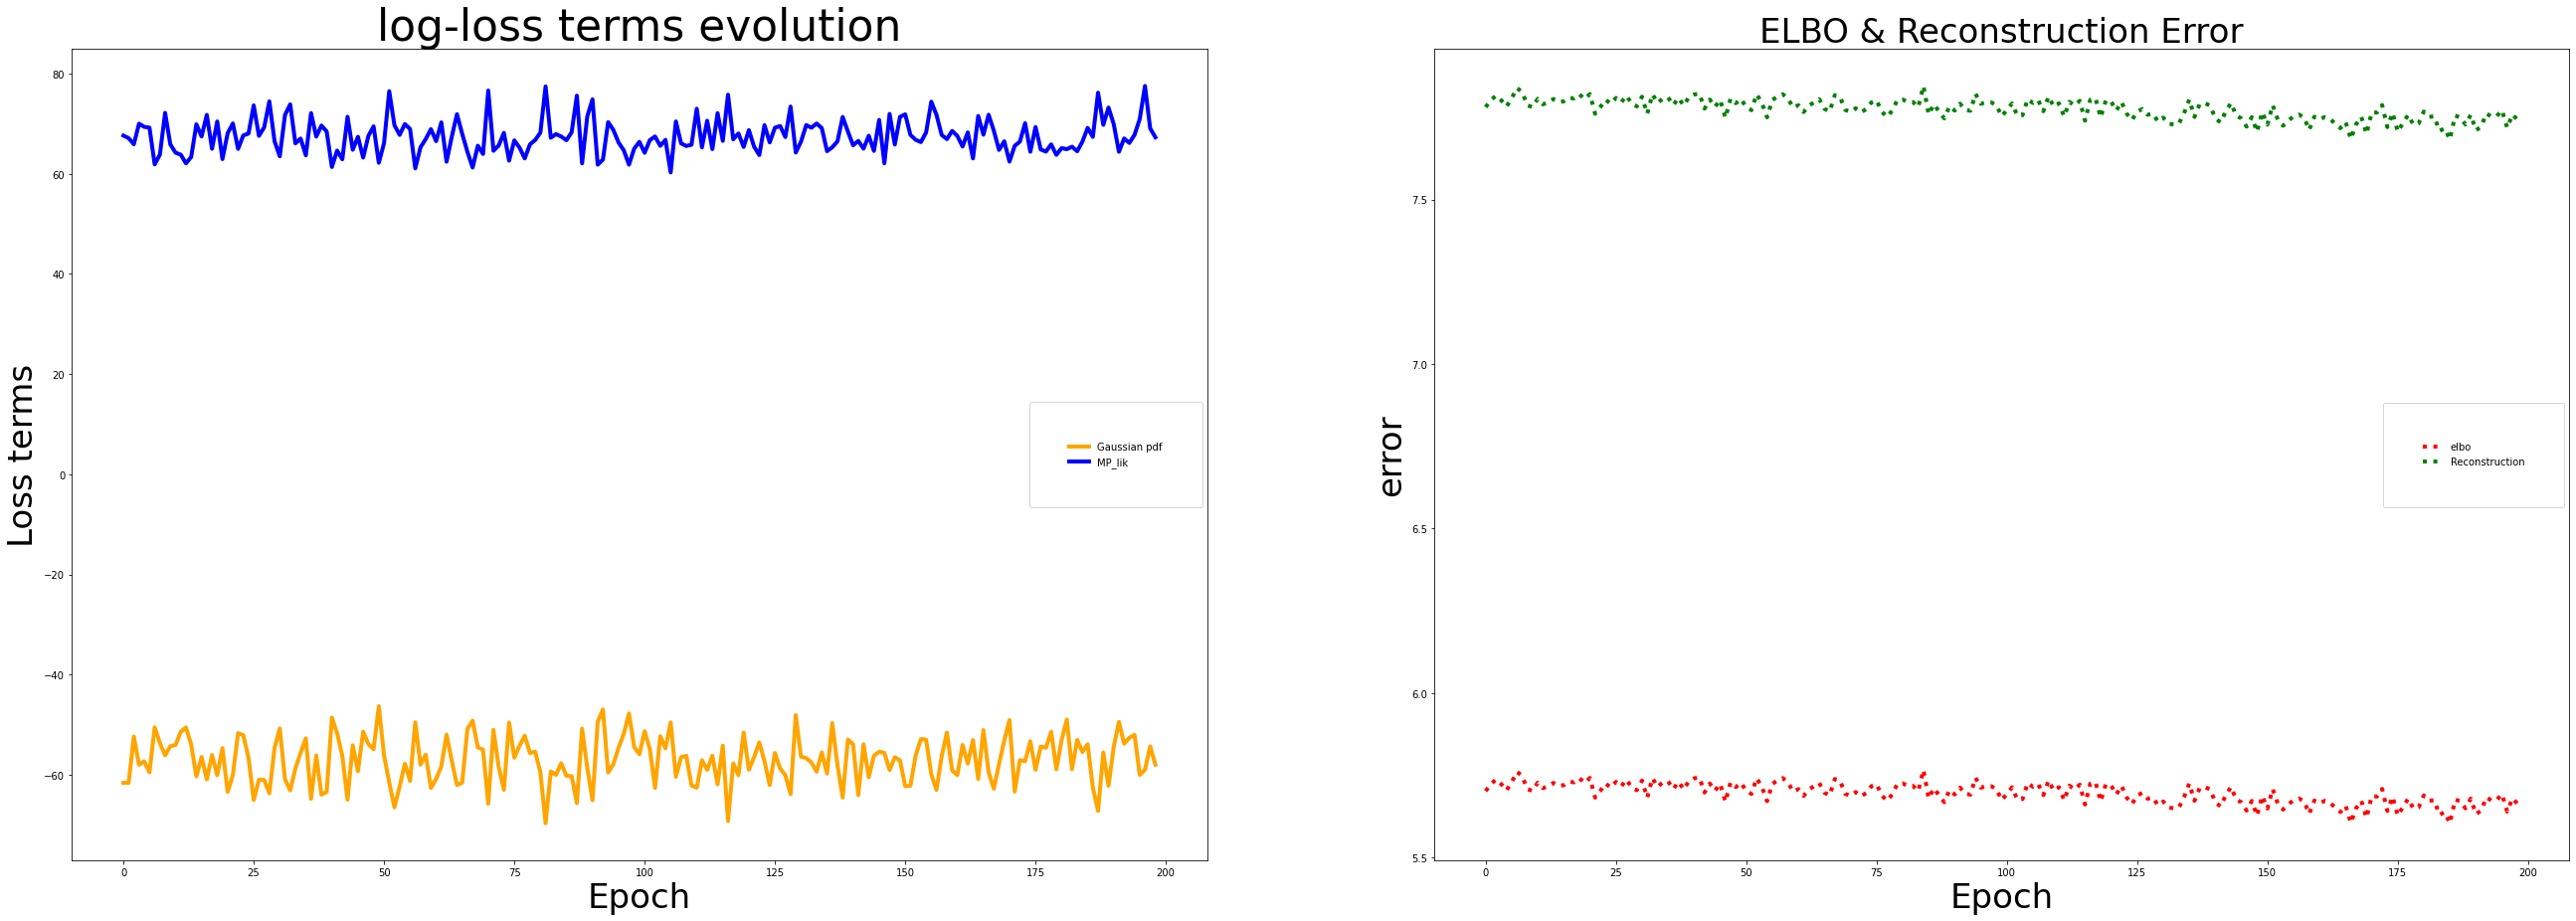

In [164]:
plot_losses(trainer)

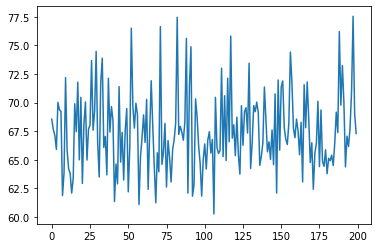

In [165]:
plt.plot(trainer.history_train['MP_lik'])

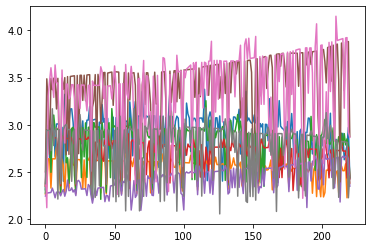

In [166]:
plt.plot(vae.encoder_variance)

In [167]:
full_posterior = trainer.create_posterior(trainer.model, cas_dataset, trainer.clades,
                                indices=np.arange(len(cas_dataset))
                                         )

***Imputation***

In [168]:
empirical_l = np.mean(np.sum(glm.X, axis=1))

# CascVI impitations
imputed = {}
imputed_z = {}
imputed_gt = {}

for n in tree.traverse('levelorder'):
    if not n.is_leaf():
        imputed[n.name], imputed_z[n.name] = full_posterior.imputation_internal(n.name,
                                                            give_mean=False,
                                                            library_size=empirical_l,
                                                           )
        imputed_gt[n.name] = glm.X[n.index]

# 3. scVI

[2021-03-23 16:14:38,879] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2021-03-23 16:14:38,881] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
training: 100%|██████████| 500/500 [00:03<00:00, 133.94it/s]


//anaconda3/envs/berkeley/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


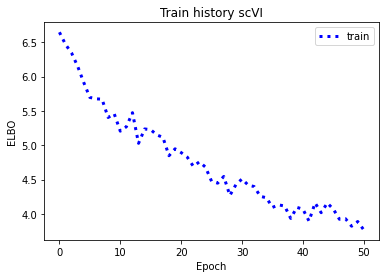

In [169]:
# anndata
gene_dataset = GeneExpressionDataset()
gene_dataset.populate_from_data(leaves_X)

n_epochs = 500

vae_scvi = VAE(gene_dataset.nb_genes,
                  n_batch=cas_dataset.n_batches * use_batches,
                  n_hidden=128,
                  n_layers=1,
                  reconstruction_loss='poisson',
                  n_latent=glm.latent)

trainer_scvi = UnsupervisedTrainer(model=vae_scvi,
                              gene_dataset=gene_dataset,
                              train_size=1.0,
                              use_cuda=use_cuda,
                              frequency=10,
                              n_epochs_kl_warmup=500)

# train scVI
trainer_scvi.train(n_epochs=n_epochs, lr=1e-3) 
                                        
elbo_train_scvi = trainer_scvi.history["elbo_train_set"]
x = np.linspace(0, 100, (len(elbo_train_scvi)))
plt.plot(np.log(elbo_train_scvi), 
         label="train", color='blue',
         linestyle=':',
         linewidth=3
        )
plt.xlabel('Epoch')
plt.ylabel("ELBO")
plt.legend()
plt.title("Train history scVI")
plt.show()

In [170]:
scvi_posterior = trainer_scvi.create_posterior(model=vae_scvi,
                                              gene_dataset=gene_dataset
                                              )

imputed_scvi, imputed_scvi_z = scvi_baseline(tree=tree, 
                                             posterior=scvi_posterior, 
                                             weighted=True,
                                            give_latent=True,
                                            n_samples_z=1)

scvi_latent = scvi_posterior.get_latent()[0]
scvi_latent.shape

(8, 5)

# 4. Likelihood ratio

In [171]:
cascvi_latent = full_posterior.get_latent()[0]
scvi_latent = scvi_posterior.get_latent()[0]
cascvi_latent.shape


(8, 5)

In [172]:
vae.initialize_visit()
vae.initialize_messages(scvi_posterior.get_latent()[0], cas_dataset.barcodes, cascvi_latent.shape[1])
vae.perform_message_passing((vae.tree & vae.root), cascvi_latent.shape[1], False)
mp_lik_scvi = vae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print("Likelihood of scVI encodings: ", mp_lik_scvi.item())

Likelihood of scVI encodings:  -64.47650762643858


In [173]:
vae.initialize_visit()
vae.initialize_messages(full_posterior.get_latent()[0], cas_dataset.barcodes, cascvi_latent.shape[1])
vae.perform_message_passing((vae.tree & vae.root), cascvi_latent.shape[1], False)
mp_lik_cascvi = vae.aggregate_messages_into_leaves_likelihood(d, add_prior=True)
print("Likelihood of cascVI encodings: ", mp_lik_cascvi.item())

Likelihood of cascVI encodings:  -55.106497576924745


In [174]:
# Likelihood ratio
lambda_ = (mp_lik_cascvi - mp_lik_scvi)
print("Likelihood Ratio:", lambda_)

Likelihood Ratio: tensor(9.3700, dtype=torch.float64)


# 5. Latent space analysis

***Full scVI latent space***

In [175]:
# Merge internal nodes and leaves
full_scvi_latent = []
idx = 0

for i, n in enumerate(tree.traverse()):
    if n.is_leaf():
        full_scvi_latent.append(scvi_latent[idx])
        idx += 1
    else:
        full_scvi_latent.append(imputed_scvi_z[n.name])
            
full_scvi_latent = np.vstack(full_scvi_latent)

***Full cascVI latent space***

In [176]:
# Merge internal nodes and leaves
full_cascvi_latent = []
idx = 0

for i, n in enumerate(tree.traverse()):
    if n.is_leaf():
        full_cascvi_latent.append(cascvi_latent[idx])
        idx += 1
    else:
        full_cascvi_latent.append(imputed_z[n.name])
            
full_cascvi_latent = np.vstack(full_cascvi_latent)
full_cascvi_latent.shape

(16, 5)

Leaves Only


/Users/khalilouardini/Desktop/projects/scVI/scvi/utils/metrics.py:143: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


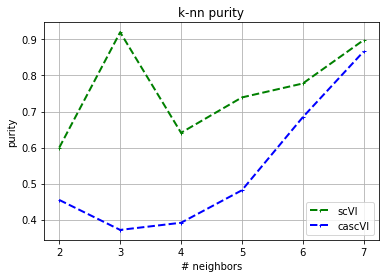

In [178]:
print("Leaves Only")
scores = knn_purity(max_neighbors=8,
              data=[leaves_z, scvi_latent, cascvi_latent],
              plot=True)

Internal nodes Only


/Users/khalilouardini/Desktop/projects/scVI/scvi/utils/metrics.py:143: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


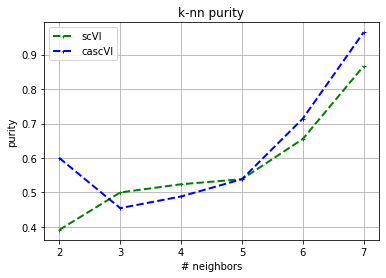

In [180]:
print("Internal nodes Only")
internal_z, internal_idx, internal_mu = get_internal(glm.z, glm.mu, tree)
internal_scvi_z, internal_idx, internal_mu = get_internal(full_scvi_latent, glm.mu, tree)
internal_cascvi_z, internal_idx, internal_mu = get_internal(full_cascvi_latent, glm.mu, tree)
scores = knn_purity(max_neighbors=8,
              data=[internal_z, internal_scvi_z, internal_cascvi_z],
              plot=True
              )

Full tree


/Users/khalilouardini/Desktop/projects/scVI/scvi/utils/metrics.py:143: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


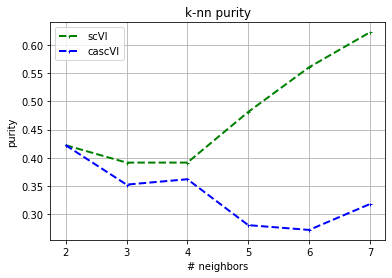

In [182]:
print("Full tree")
scores = knn_purity(max_neighbors=8,
              data=[glm.z, full_scvi_latent, full_cascvi_latent],
              plot=True)